# Neural networks code and tests notebook

# This notebook takes the flux, photon index and fratio data and try to predict classes from this data on a :

# - LSTM network
# - ConvLSTM network
# - Conv1D network

In [1]:
import numpy as np
from numpy import random
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import math
from scipy import interpolate
import sys 
from re import search
from astropy.io import fits
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude
import shutil
from keras.callbacks import CSVLogger
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import glob
from datetime import datetime
from keras.layers import Conv1D, Dense, Dropout, Input, Concatenate, GlobalMaxPooling1D, BatchNormalization
from keras.layers.convolutional import MaxPooling1D
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
import tensorflow.keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten,LSTM
from keras.utils import to_categorical
from keras.layers import Dense, Activation, Concatenate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit # or StratifiedShuffleSplit
from pandas import DataFrame
from pyts.classification import BOSSVS
from pyts.multivariate.classification import MultivariateClassifier
import shutil
from keras.callbacks import CSVLogger
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit # or StratifiedShuffleSplit
from pandas import DataFrame
import sktime
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

In [2]:
pathON="C:/Users/pierr/Documents_kanop/Shps/Pierre_points_for_louis/Bureau/interpo_ONOFF/Luigino/ON_data/"
pathOFF="C:/Users/pierr/Documents_kanop/Shps/Pierre_points_for_louis/Bureau/interpo_ONOFF/Luigino/OFF_data/"

In [3]:
#Storing in a list the adresses of all the data files in the notebook

data_files_ON=[]
file_names_ON=[]

data_files_OFF=[]
file_names_OFF=[]
data_files_ALL=[]
file_names_ALL=[]

#Storing in a list the adresses of all the data files in the notebook
for filename in os.listdir(pathOFF):
    f = os.path.join(pathOFF,filename)
    if os.path.isfile(f):
        data_files_OFF.append(f)
        file_names_OFF.append(filename)
        data_files_ALL.append(f)
        file_names_ALL.append(filename)
for filename in os.listdir(pathON):
    f = os.path.join(pathON,filename)
    if os.path.isfile(f):
        data_files_ON.append(f)
        file_names_ON.append(filename)
        data_files_ALL.append(f)
        file_names_ALL.append(filename)        

In [4]:
#Using data_files with only the 36 binning
Filter=True
binning=37


if Filter==True:
    
    idx_OFF=[]
    idx_ON=[]
    dataON=[]
    dataOFF=[]
    for i in range(len(data_files_OFF)):
        dataframe = pd.read_csv(data_files_OFF[i])
        lg = len(dataframe)
        
        if lg==binning:
            idx_OFF.append(i)
    
    for i in range(len(data_files_ON)):
        dataframe = pd.read_csv(data_files_ON[i])
        lg = len(dataframe)
        if lg==binning:
            idx_ON.append(i)


    for i in range(len(idx_OFF)):

        a=idx_OFF[i]
        dataOFF.append(data_files_OFF[a])
    for i in range(len(idx_ON)):

        a=idx_ON[i]
        dataON.append(data_files_ON[a])

idx = idx_OFF+idx_ON


In [5]:


lgON=len(dataON)
lgOFF=len(dataOFF)
lg=lgON+lgOFF
Labels = []

nbfeatures=1

a=binning
b=nbfeatures
c=lg

# multivariate

data_matrix= np.zeros((b,c,a))

#Construct data matrix
for j in range(len(dataOFF)):

    dataframe=pd.read_csv(dataOFF[j],index_col=[0])
    dataframe.columns=['MJD','Flux','Delta Flux','Photon Index','Delta Index','TS','fratio']

    data_matrix[0][j]=dataframe['Flux']
#     data_matrix[1][j]=dataframe['Photon Index']
    
for j in range(len(dataON)):

    v=j+len(dataOFF)
    dataframe=pd.read_csv(dataON[j],index_col=[0])
    dataframe.columns=['MJD','Flux','Delta Flux','Photon Index','Delta Index','TS','fratio']

    data_matrix[0][v]=dataframe['Flux']
#     data_matrix[1][v]=dataframe['Photon Index']
    
#Creating labels
for i in range(lgOFF):
    
    Labels.append(int(0))
    
for i in range(lgON):
    Labels.append(int(1))



In [6]:
#Reshaping data matrix
data_matrix=data_matrix.reshape(c,nbfeatures,binning)

In [7]:
#LSTM architecture
from keras.layers import Conv1D
from sklearn.metrics import f1_score
ON_accuracy=[]
OFF_accuracy=[]
fscore=[]
FPOS=[]
FNEG= []

weight_for_0 = (1 / lgOFF) * (lg / 2.0)
weight_for_1 = (1 / lgON) * (lg / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}
callback=tensorflow.keras.callbacks.EarlyStopping(monitor='binary_accuracy',patience=6, verbose=0, mode='auto',baseline=None, restore_best_weights=True)




for i in range(5):
    
    model = Sequential()
    model.add(LSTM(9,input_shape=(nbfeatures,binning),activation='tanh'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss=tensorflow.keras.losses.BinaryCrossentropy(reduction='sum'),optimizer='SGD', metrics=['binary_accuracy'])
    
    x_train, x_test, y_train, y_test = train_test_split(data_matrix, Labels, test_size=0.2, random_state=i)
    y_test2=y_test.copy()
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    
    #fitting data
    model.fit(x_train, y_train,epochs=20,batch_size=1,class_weight=class_weight,callbacks=callback)

    print('Iteration no.',i)
    #Obtain the accuracy of prediction for each class
    prediction= model.predict(x_test)
    predicted_labels=[]
    
    for i in range(len(prediction)):
        if prediction[i][0]>0.5:
            predicted_labels.append(0)
        else:
            predicted_labels.append(1)
    on_score=0
    on_nbs=0
    off_nbs=0
    off_score=0
    foff=0
    fon=0
    for i in range(len(y_test)):
        if y_test2[i]==1 :
            on_nbs+=1
            if predicted_labels[i]==1:
                on_score+=1
            else : 
                fon+=1
        if y_test2[i]==0 :
            off_nbs+=1
            if predicted_labels[i]==0:
                off_score+=1 
            else:
                foff+=1
    if on_nbs>0:    
        ON_accuracy.append(100*(on_score/on_nbs))
        FPOS.append(100*(fon/on_nbs))
    OFF_accuracy.append(100*(off_score/off_nbs))
    FNEG.append(100*(foff/off_nbs))
    f1= f1_score(y_test2,predicted_labels)
    fscore.append(f1)
print("Accuracy for ON class: ",np.mean(ON_accuracy) ,"%")
print("Accuracy for OFF class: ",np.mean(OFF_accuracy) ,"%")
print("False Positive rate: ",np.mean(FPOS) ,"%")
print("False Negative rate: ",np.mean(FNEG) ,"%")
print("F1 score: ",np.mean(fscore))

Epoch 1/20
912/912 [==============================] - 4s 2ms/step - loss: 0.6930 - binary_accuracy: 0.7615
Epoch 2/20
912/912 [==============================] - 2s 2ms/step - loss: 0.6931 - binary_accuracy: 0.4485
Epoch 3/20
912/912 [==============================] - 2s 2ms/step - loss: 0.6928 - binary_accuracy: 0.2971
Epoch 4/20
912/912 [==============================] - 2s 2ms/step - loss: 0.6929 - binary_accuracy: 0.6075
Epoch 5/20
912/912 [==============================] - 2s 2ms/step - loss: 0.6929 - binary_accuracy: 0.7445
Epoch 6/20
912/912 [==============================] - 2s 2ms/step - loss: 0.6930 - binary_accuracy: 0.6601
Epoch 7/20
912/912 [==============================] - 2s 2ms/step - loss: 0.6924 - binary_accuracy: 0.6086
Iteration no. 0
8/8 [==============================] - 1s 2ms/step
Epoch 1/20
912/912 [==============================] - 3s 2ms/step - loss: 0.7052 - binary_accuracy: 0.3438
Epoch 2/20
912/912 [==============================] - 2s 2ms/step - loss: 0.7

KeyboardInterrupt: 

In [29]:
# Conv/LSTM architecture
#LSTM architecture
from keras.layers import Conv1D
from sklearn.metrics import f1_score
ON_accuracy=[]
OFF_accuracy=[]
fscore=[]
FPOS=[]
FNEG= []

weight_for_0 = (1 / lgOFF) * (lg / 2.0)
weight_for_1 = (1 / lgON) * (lg / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}
callback=tensorflow.keras.callbacks.EarlyStopping(monitor='binary_accuracy',patience=6, verbose=0, mode='auto',baseline=None, restore_best_weights=True)




for i in range(1):
    
    model = Sequential()
    model.add(Dense(binning, activation='tanh', input_shape=(nbfeatures,binning),input_dim=nbfeatures))
    model.add(Conv1D(filters=20, kernel_size=1, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(20,input_shape=(20, nbfeatures), activation='tanh'))
    model.add(Flatten())
    model.add(Dense(2, activation='softmax'))
    model.compile(loss=tensorflow.keras.losses.BinaryCrossentropy(reduction='sum'),optimizer='SGD', metrics=['binary_accuracy'])
    x_train, x_test, y_train, y_test = train_test_split(data_matrix, Labels, test_size=0.2, random_state=i)
    y_test2=y_test.copy()
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    
    #fitting data
    model.fit(x_train, y_train,epochs=10,batch_size=1,class_weight=class_weight,callbacks=callback)

    print('Iteration no.',i)
    #Obtain the accuracy of prediction for each class
    prediction= model.predict(x_test)
    predicted_labels=[]
    
    for i in range(len(prediction)):
        if prediction[i][0]>0.5:
            predicted_labels.append(0)
        else:
            predicted_labels.append(1)
    on_score=0
    on_nbs=0
    off_nbs=0
    off_score=0
    foff=0
    fon=0
    for i in range(len(y_test)):
        if y_test2[i]==1 :
            on_nbs+=1
            if predicted_labels[i]==1:
                on_score+=1
            else : 
                fon+=1
        if y_test2[i]==0 :
            off_nbs+=1
            if predicted_labels[i]==0:
                off_score+=1 
            else:
                foff+=1
    if on_nbs>0:    
        ON_accuracy.append(100*(on_score/on_nbs))
        FPOS.append(100*(fon/on_nbs))
    OFF_accuracy.append(100*(off_score/off_nbs))
    FNEG.append(100*(foff/off_nbs))
    f1= f1_score(y_test2,predicted_labels)
    fscore.append(f1)
print("Accuracy for ON class: ",np.mean(ON_accuracy) ,"%")
print("Accuracy for OFF class: ",np.mean(OFF_accuracy) ,"%")
print("False Positive rate: ",np.mean(FPOS) ,"%")
print("False Negative rate: ",np.mean(FNEG) ,"%")
print("F1 score: ",np.mean(fscore))
print('prec')

Epoch 1/10
912/912 [==============================] - 4s 2ms/step - loss: 0.6926 - binary_accuracy: 0.3054
Epoch 2/10
912/912 [==============================] - 2s 2ms/step - loss: 0.6934 - binary_accuracy: 0.8103
Epoch 3/10
912/912 [==============================] - 2s 2ms/step - loss: 0.6932 - binary_accuracy: 0.6305
Epoch 4/10
912/912 [==============================] - 2s 2ms/step - loss: 0.6932 - binary_accuracy: 0.4583
Epoch 5/10
912/912 [==============================] - 2s 2ms/step - loss: 0.6923 - binary_accuracy: 0.6754
Epoch 6/10
912/912 [==============================] - 2s 2ms/step - loss: 0.6931 - binary_accuracy: 0.3257
Epoch 7/10
912/912 [==============================] - 2s 2ms/step - loss: 0.6933 - binary_accuracy: 0.3344
Epoch 8/10
912/912 [==============================] - 2s 2ms/step - loss: 0.6931 - binary_accuracy: 0.7039
Iteration no. 0
8/8 [==============================] - 0s 2ms/step
Accuracy for ON class:  0.0 %
Accuracy for OFF class:  100.0 %
False Positive

In [ ]:
from sklearn.metrics import precision_score
print(precision_score(y_test2, predicted_labels))

In [49]:
from sklearn.metrics import f1_score

ON_accuracy=[]
OFF_accuracy=[]
fscore=[]
FPOS=[]
FNEG=[]
#Measuring the meaned accuracy of  correct prediction of labellisation for each class  over a defined number of steps
for i in range(1):
    nb_filters=20
    
#     callback=tensorflow.keras.callbacks.EarlyStopping(monitor='binary_accuracy',patience=6, verbose=0, mode='auto',baseline=None, restore_best_weights=True)

    #Conv1D Architecture
    model = Sequential()
    model.add(Conv1D(nb_filters, 1, padding="same", activation="relu",input_shape=(nbfeatures,binning)))
    model.add(Conv1D(15, 1, padding="same", activation="relu",input_shape=(nb_filters,binning)))
    model.add(Conv1D(9, 1, padding="same", activation="relu",input_shape=(15,binning)))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(9, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='binary_crossentropy',optimizer='SGD', metrics=['binary_accuracy'])


    x_train, x_test, y_train, y_test = train_test_split(data_matrix, Labels, test_size=0.3, random_state=i)
    y_test2=y_test.copy()
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    
    #fitting data
    model.fit(x_train, y_train,epochs=200,batch_size=1,class_weight=class_weight)

    print('Iteration no.',i)
    #Obtain the accuracy of prediction for each class
    prediction= model.predict(x_test)
    predicted_labels=[]
    
    for i in range(len(prediction)):
        if prediction[i][0]>0.5:
            predicted_labels.append(0)
        else:
            predicted_labels.append(1)
    on_score=0
    on_nbs=0
    off_nbs=0
    off_score=0
    foff=0
    fon=0
    for i in range(len(y_test)):
        if y_test2[i]==1 :
            on_nbs+=1
            if predicted_labels[i]==1:
                on_score+=1
            else : 
                fon+=1
        if y_test2[i]==0 :
            off_nbs+=1
            if predicted_labels[i]==0:
                off_score+=1 
            else:
                foff+=1
    if on_nbs>0:    
        ON_accuracy.append(100*(on_score/on_nbs))
        FPOS.append(100*(fon/on_nbs))
    OFF_accuracy.append(100*(off_score/off_nbs))
    FNEG.append(100*(foff/off_nbs))
    f1= f1_score(y_test2,predicted_labels,average='weighted')
    fscore.append(f1)
print("Accuracy for ON class: ",np.mean(ON_accuracy) ,"%")
print("Accuracy for OFF class: ",np.mean(OFF_accuracy) ,"%")
print("False Positive rate: ",np.mean(FPOS) ,"%")
print("False Negative rate: ",np.mean(FNEG) ,"%")
print("F1 score: ",np.mean(fscore))

Epoch 1/200
798/798 [==============================] - 2s 2ms/step - loss: 0.6823 - binary_accuracy: 0.5470
Epoch 2/200
798/798 [==============================] - 1s 2ms/step - loss: 0.6822 - binary_accuracy: 0.8972
Epoch 3/200
798/798 [==============================] - 1s 2ms/step - loss: 0.6824 - binary_accuracy: 0.8972
Epoch 4/200
798/798 [==============================] - 1s 2ms/step - loss: 0.6812 - binary_accuracy: 0.3095
Epoch 5/200
798/798 [==============================] - 1s 2ms/step - loss: 0.6825 - binary_accuracy: 0.8972
Epoch 6/200
798/798 [==============================] - 1s 2ms/step - loss: 0.6822 - binary_accuracy: 0.8747
Epoch 7/200
798/798 [==============================] - 1s 2ms/step - loss: 0.6823 - binary_accuracy: 0.8972
Epoch 8/200
798/798 [==============================] - 1s 2ms/step - loss: 0.6822 - binary_accuracy: 0.7356
Epoch 9/200
798/798 [==============================] - 1s 1ms/step - loss: 0.6822 - binary_accuracy: 0.7105
Epoch 10/200
798/798 [======

798/798 [==============================] - 1s 1ms/step - loss: 0.6822 - binary_accuracy: 0.6830
Epoch 77/200
798/798 [==============================] - 1s 1ms/step - loss: 0.6823 - binary_accuracy: 0.8058
Epoch 78/200
798/798 [==============================] - 1s 1ms/step - loss: 0.6821 - binary_accuracy: 0.6867
Epoch 79/200
798/798 [==============================] - 1s 2ms/step - loss: 0.6819 - binary_accuracy: 0.8972
Epoch 80/200
798/798 [==============================] - 1s 1ms/step - loss: 0.6822 - binary_accuracy: 0.6316
Epoch 81/200
798/798 [==============================] - 1s 1ms/step - loss: 0.6823 - binary_accuracy: 0.8835
Epoch 82/200
798/798 [==============================] - 1s 2ms/step - loss: 0.6823 - binary_accuracy: 0.8847
Epoch 83/200
798/798 [==============================] - 1s 1ms/step - loss: 0.6819 - binary_accuracy: 0.5150
Epoch 84/200
798/798 [==============================] - 1s 2ms/step - loss: 0.6824 - binary_accuracy: 0.8910
Epoch 85/200
798/798 [==========

798/798 [==============================] - 1s 1ms/step - loss: 0.6820 - binary_accuracy: 0.8972
Epoch 151/200
798/798 [==============================] - 1s 1ms/step - loss: 0.6823 - binary_accuracy: 0.7231
Epoch 152/200
798/798 [==============================] - 1s 1ms/step - loss: 0.6821 - binary_accuracy: 0.6642
Epoch 153/200
798/798 [==============================] - 1s 1ms/step - loss: 0.6813 - binary_accuracy: 0.4211
Epoch 154/200
798/798 [==============================] - 1s 1ms/step - loss: 0.6824 - binary_accuracy: 0.8133
Epoch 155/200
798/798 [==============================] - 1s 1ms/step - loss: 0.6824 - binary_accuracy: 0.8584
Epoch 156/200
798/798 [==============================] - 1s 1ms/step - loss: 0.6823 - binary_accuracy: 0.8596
Epoch 157/200
798/798 [==============================] - 1s 1ms/step - loss: 0.6821 - binary_accuracy: 0.8972
Epoch 158/200
798/798 [==============================] - 1s 1ms/step - loss: 0.6822 - binary_accuracy: 0.7632
Epoch 159/200
798/798 [=

In [48]:
dens = model.predict(x_test)

#print(dens)

OFFF=[]
ONN=[]
idx_ON=[]
idx_OFF=[]
for i in range(len(y_test2)):
    
    if y_test2[i]==1:
        idx_ON.append(i)
    if y_test2[i]==0:
        idx_OFF.append(i)        

         
for i in range(len(dens)):
        
        OFFF.append(dens[i][0])
        ONN.append(dens[i][1])
        
ONN_true=[ONN[j] for j in idx_ON]
OFF_true=[ONN[j] for j in idx_OFF]

print(ONN_true)

11/11 [==============================] - 0s 1ms/step
[0.47833544, 0.47833544, 0.47833544, 0.47833544, 0.47833544, 0.47833544, 0.47833544, 0.47833544, 0.47833544, 0.47833544, 0.47833544, 0.47833544, 0.47833544, 0.47833544, 0.47833544, 0.47833544, 0.47833544, 0.47833544, 0.47833544, 0.47833544, 0.47833544, 0.47833544, 0.47833544, 0.47833544, 0.47833544, 0.47833544, 0.47833544, 0.47833544, 0.47833544, 0.47833544, 0.47833544, 0.47833544, 0.47833544, 0.47833544, 0.47833544, 0.47833544, 0.47833544, 0.47833544, 0.47833544, 0.47833544]


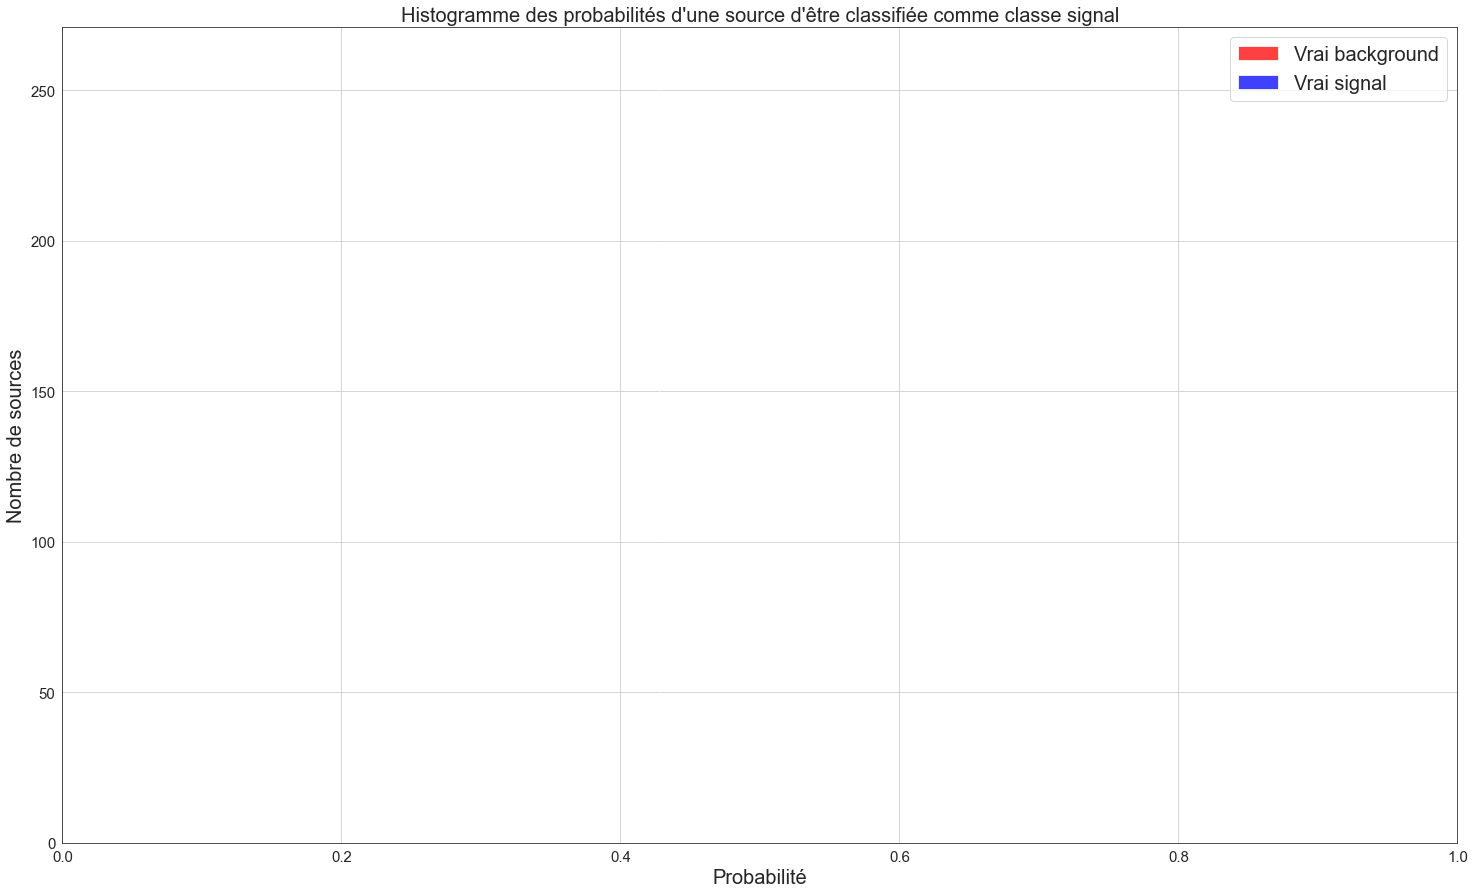

In [37]:
import seaborn as sns
sns.set_style("white")

# Plotting  model score distribution

#kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

colors = ['r','b']
labels=['Vrai background','Vrai signal']
fig = plt.figure(figsize=(25,15))
# ax1 = fig1.add_subplot(121)
plt.hist([OFF_true,ONN_true],50,color=colors,label=labels,alpha=0.75)
plt.xlabel("Probabilité",fontsize=20)
plt.ylabel("Nombre de sources",fontsize=20)
plt.title("Histogramme des probabilités d'une source d'être classifiée comme classe signal",fontsize=20)
#ax1.hist(OFF_true,20,color="r", label="Prob of being ON for all LC",density=True,alpha=0.75)
#ax1.hist(ONN_true,20,color="b", label="Prob of being ON for all LC",density=True,alpha=0.75)

#sns.distplot(ONN, color="g", label="Prob of beiung ON for all LC")
#sns.distplot(OFF_true, color="r", label="Prob of being ON for OFF LC")

plt.xlim(0,1)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
#sns.distplot(ONN, color="dodgerblue", label="Prob ON")
#sns.distplot(OFFF, color="orange", label="OFF")
#plt.title("Score density")
# plt.yscale('log')
#plt.xlim(0,1)
#plt.ylim(0.01,800)
plt.grid()

plt.legend(fontsize=20);

In [32]:
OFF_true

[0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.49764633,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.49764633,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.49764633,
 0.4976463,
 0.49764633,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.49764633,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,

In [33]:
ONN_true

[0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.49764633,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.4976463,
 0.49764633]